# Build an image segementation model with torchgeo

Author: Wenxin Yang, 08/12/2024

<b>Purpose of script:</b>

Using the training samples (images and annotations), we build a unet model to extract parks with torchgeo.

<b>References:</b>

* [A series of online tutorials by Maurício Cordeiro](https://www.geocorner.net/post/artificial-intelligence-for-geospatial-analysis-with-pytorch-s-torchgeo-part-1)
* [Official GitHub of torchgeo](https://github.com/microsoft/torchgeo/tree/main)

In [1]:
import os
import tempfile
from urllib.parse import urlparse
import math
import splitfolders

import matplotlib.pyplot as plt
# import planetary_computer
# import pystac

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, Units

In [2]:
# checking both insallations
import rasterio as rio
import torchgeo

from pathlib import  Path
import xarray as xr

### 1. Prepare data folders

Get paths to our sample dataset

In [3]:
os.getcwd()

'C:\\Users\\wenxinyang\\Desktop\\GitHub\\UGS_iguide2024\\script'

In [4]:
# make sure the path to our training samples exist
root = Path('..\\data\\training_samples')
assert root.exists()

As discussed briefly in the last notebook, there are some na values not covered by the image (e.g., whether it being out of the extent of the current image or it being waterbodies). Here, we are removing any chips with na values. Admittedly, this might not be the best way.

In [5]:
# remove any images with NA values in the dataset
n = 0
for filename in os.listdir(os.path.join(root, 'images')):
    path_file = os.path.join(root, 'images', filename)
    file = rio.open(path_file)
    test_value = file.read(1).max()
    file.close()
    if math.isnan(test_value):
        print(filename)
        n = n + 1
        os.remove(os.path.join(root, 'images', filename))

print(n)

0


In [6]:
img_ids = [x for x in os.listdir(os.path.join(root, 'images')) if x.endswith('.tif')]
len(img_ids)

415

In [7]:
# we also remove unmatched files
for filename in os.listdir(os.path.join(root, 'annotations')):
    if filename not in img_ids:
        print(filename)
        os.remove(os.path.join(root, 'annotations', filename))

In [8]:
sample_imgs = list((root/'images').glob('*.tif'))
sample_masks = list((root/'annotations').glob('*.tif'))

In [9]:
# see how many chips we have 
len(sample_masks)

415

In [10]:
# double check to make sure we have the same amount of images and annotations
len(sample_imgs) == len(sample_masks)

True

Let's split the dataset into train, validation, and test datasets

In [11]:
# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
sample_imgs.sort(); sample_masks.sort()

In [17]:
splitfolders.ratio(os.path.join(root), output=Path('..\\data\\experiment_1'),
    seed=226, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 830 files [00:01, 703.08 files/s] 


Now let's move on to create inputs for the model

In [12]:
exp_folder = Path('..\\data\\experiment_1')
exp_crs = 'epsg:26918'
exp_res = 30

In [13]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [14]:
train_imgs = RasterDataset(os.path.join(exp_folder, 'train', 'images'), crs=exp_crs, res=exp_res, transforms=scale)
train_msks = RasterDataset(os.path.join(exp_folder, 'train', 'annotations'), crs=exp_crs, res=exp_res)

valid_imgs = RasterDataset(os.path.join(exp_folder, 'val', 'images'), crs=exp_crs, res=exp_res, transforms=scale)
valid_msks = RasterDataset(os.path.join(exp_folder, 'val', 'annotations'), crs=exp_crs, res=exp_res)

In [15]:
len(train_imgs)

332

In [16]:
len(valid_imgs)

41

In [17]:
# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

In [18]:
print(train_dset)

IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=-1547075.146921655, maxx=-1437998.5057360458, miny=3426936.12106045, maxy=3526592.039209696, mint=0.0, maxt=9.223372036854776e+18)
    size: 5222


In [19]:
train_sampler = RandomGeoSampler(train_imgs, size=(255, 255), length=10, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=(255, 255), length=10, units=Units.PIXELS)

In [20]:
len(train_sampler)

10

In [21]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [91]:
train_batch['image'][0][0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0052, 0.0053, 0.0055],
        [0.0000, 0.0000, 0.0000,  ..., 0.0060, 0.0055, 0.0055],
        [0.0000, 0.0000, 0.0000,  ..., 0.0063, 0.0056, 0.0054],
        ...,
        [0.0105, 0.0108, 0.0108,  ..., 0.0081, 0.0088, 0.0087],
        [0.0108, 0.0105, 0.0105,  ..., 0.0083, 0.0089, 0.0088],
        [0.0000, 0.0000, 0.0000,  ..., 0.0089, 0.0088, 0.0098]])

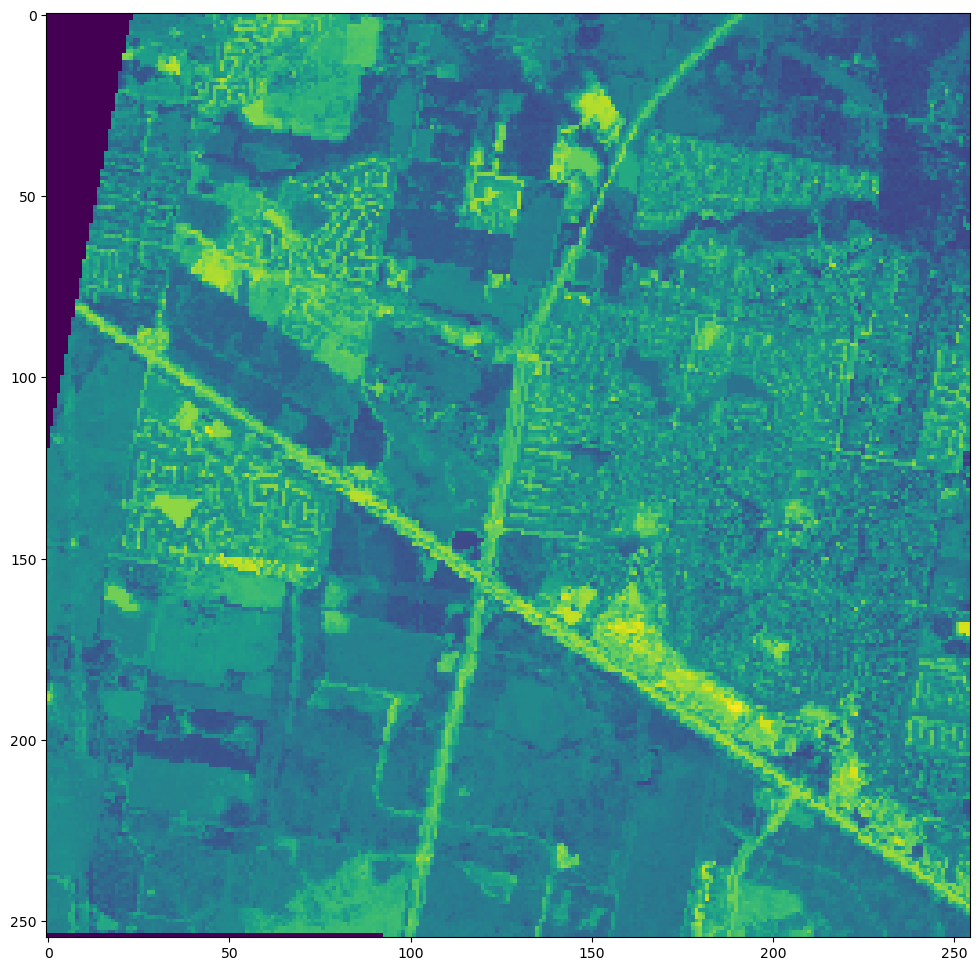

In [92]:
plt.imshow(train_batch['image'][0][0])

### 2. Normalize data

In [22]:
import rasterio as rio

def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [23]:
files = [item.object for item in train_imgs.index.intersection(train_imgs.index.bounds, objects = True)]

In [24]:
mean, std = calc_statistics(train_imgs)
print(mean, std)

[0.01192544 0.01298434 0.01128159 0.01379109] [0.00345744 0.00295965 0.00308488 0.00306698]


In [99]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: list[float], stdev: list[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.
        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

In [100]:
normalize = MyNormalize(mean=mean, stdev=std)
# norm_batch = normalize(train_batch)
# plot_batch(norm_batch)

# batch = normalize.revert(norm_batch)
# # plot_batch(batch)

### 3. Train a segmentation model

In [26]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights=None, num_classes=2)

model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

num_classes is set to 2 for UGS and non-UGS, so in the output, there will be 2 channels --> channel 1 indicating if it is class 0 (non-UGS), channel 2 indicating if it is class 1 (UGS)

In [27]:
backbone = model.get_submodule('backbone')

In [28]:
conv = torch.nn.modules.conv.Conv2d(
    in_channels=4, 
    out_channels=64, 
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)

In [29]:
backbone.register_module('conv1', conv)

See the difference in shapes

In [30]:
pred = model(torch.randn(3, 4, 255, 255))
pred['out'].shape

torch.Size([3, 2, 255, 255])

In [31]:
valid_batch['mask'][0].shape

torch.Size([1, 255, 255])

<b>Train loop</b>

In [32]:
from typing import Optional, Callable

In [33]:
def train_loop(
    epochs: int, 
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[list]=None, 
    batch_tfms: Optional[Callable]=None
):
    # size = len(dataloader.dataset)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    cuda_model = model.to(device)

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:

            if batch_tfms is not None:
                batch = batch_tfms(batch)

            X = batch['image'].to(device)
            y = batch['mask'].type(torch.long).to(device)
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:

                    if batch_tfms is not None:
                        batch = batch_tfms(batch)                    

                    X = batch['image'].type(torch.float32).to(device)
                    y = batch['mask'].type(torch.long).to(device)

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}')
        else:
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

<b>Define loss and accuracy functions</b>

In [34]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)    

def loss_cross_entropy(p, t):    
    return torch.nn.functional.cross_entropy(p, t.squeeze())

def loss(pred, y): # MAE
    return torch.nn.L1Loss(pred, y)

Understanding these metrics is very important!

Some helpful links:
* [Cross entropy loss](https://wiki.cloudfactory.com/docs/mp-wiki/loss/cross-entropy-loss#:~:text=Cross%2DEntropy%20%3C%200.20%3A%20Fine,2.00%20Something%20is%20seriously%20broken.)

## Training

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [36]:
%%time
train_loop(15, train_dataloader, valid_dataloader, model, loss_cross_entropy, optimizer, 
           acc_fns=[oa, iou], batch_tfms=None)

Epoch 0: Train Loss=0.70578 - Accs=[0.525, 0.021]
Epoch 1: Train Loss=0.68243 - Accs=[0.635, 0.013]
Epoch 2: Train Loss=0.65944 - Accs=[0.68, 0.044]
Epoch 3: Train Loss=0.64034 - Accs=[0.715, 0.031]
Epoch 4: Train Loss=0.62038 - Accs=[0.782, 0.01]
Epoch 5: Train Loss=0.59359 - Accs=[0.859, 0.019]
Epoch 6: Train Loss=0.56530 - Accs=[0.875, 0.012]
Epoch 7: Train Loss=0.53851 - Accs=[0.908, 0.015]
Epoch 8: Train Loss=0.51439 - Accs=[0.949, 0.006]
Epoch 9: Train Loss=0.46420 - Accs=[0.959, 0.019]
Epoch 10: Train Loss=0.43608 - Accs=[0.977, 0.001]
Epoch 11: Train Loss=0.41744 - Accs=[0.968, 0.001]
Epoch 12: Train Loss=0.36053 - Accs=[0.94, 0.0]
Epoch 13: Train Loss=0.33449 - Accs=[0.969, 0.0]
Epoch 14: Train Loss=0.31598 - Accs=[0.946, 0.0]
CPU times: total: 37min 9s
Wall time: 7min 32s


### Predict

In [37]:
valid_batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [38]:
test_model = model

In [64]:
def create_sample(batch, out, batch_idx):
    return {
        "image": batch["image"][batch_idx],  # Image
        "mask": batch["mask"][batch_idx],  # Actual masks
        "prediction": out['out'][batch_idx]  # Model predictions
        # "prediction_scores": out['out'][batch_idx]["scores"],  # Confidence scores for each prediction
    }

In [104]:
norm_batch = normalize(train_batch)
# test_batch = normalize.revert(train_batch)

In [102]:
batch_idx = 7

test_model.eval()
with torch.no_grad():
  out = test_model(norm_batch["image"])
    
# out = model(valid_batch["image"])
sample = create_sample(norm_batch, out, batch_idx)

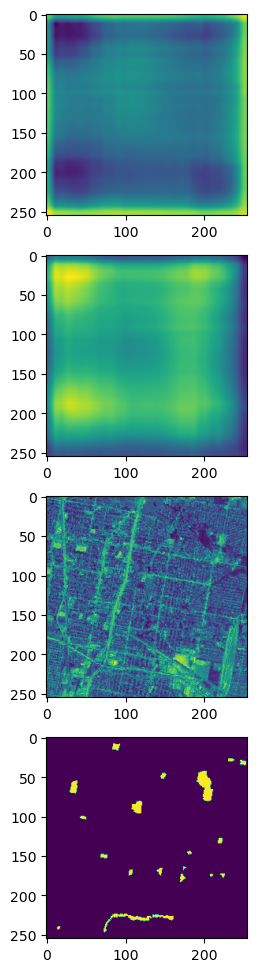

In [105]:
imgs = sample['prediction']

f, axarr = plt.subplots(imgs.size(0)+2)

for idx in range(imgs.size(0)+1):
    if(idx < imgs.size(0)):
        img = imgs[idx,].squeeze().numpy()
        axarr[idx].imshow(img)
    else:
        img1 = sample['image'][0]
        axarr[idx].imshow(img1)
        img2 = sample["mask"].permute(1,2,0)
        axarr[idx+1].imshow(img2)